In [9]:
from pyathena import connect
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Establish Athena connection using boto3 profile
conn = connect(
    s3_staging_dir='s3://insightsrxdata/AWSLogs/',
    region_name='ap-south-1', 
    profile_name='my-session-1'  
)

# List tables in the database to find the correct table name
list_tables_query = "SHOW TABLES IN insightsrx_db"
tables_df = pd.read_sql(list_tables_query, conn)
print("Available tables in insightsrx_db:")
print(tables_df)


/tmp/ipykernel_209926/4222667596.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables_df = pd.read_sql(list_tables_query, conn)


Available tables in insightsrx_db:
                   tab_name
0                department
1                 emergency
2                 financial
3                  hospital
4   hospital_administration
5                       icu
6                 inpatient
7                       lab
8                outpatient
9        patient_experience
10           patient_safety
11                 pharmacy
12                radiology
13                    staff
14                  surgery


In [6]:
emergency_query = """SELECT * FROM insightsrx_db.emergency LIMIT 100"""
icu_query = """SELECT * FROM insightsrx_db.icu LIMIT 100"""
inpatient_query = """SELECT * FROM insightsrx_db.inpatient LIMIT 100"""
outpatient_query = """SELECT * FROM insightsrx_db.outpatient LIMIT 100"""
radiology_query = """SELECT * FROM insightsrx_db.radiology LIMIT 100"""
surgery_query = """SELECT * FROM insightsrx_db.surgery LIMIT 100"""
lab_query = """SELECT * FROM insightsrx_db.lab LIMIT 100"""
patient_experience_query = """SELECT * FROM insightsrx_db.patient_experience LIMIT 100"""
patient_safety_query = """SELECT * FROM insightsrx_db.patient_safety LIMIT 100"""

# Execute the queries and fetch results
emergency_df = pd.read_sql(emergency_query, conn)
icu_df = pd.read_sql(icu_query, conn)
inpatient_df = pd.read_sql(inpatient_query, conn)       
outpatient_df = pd.read_sql(outpatient_query, conn)
radiology_df = pd.read_sql(radiology_query, conn)   
surgery_df = pd.read_sql(surgery_query, conn)
lab_df = pd.read_sql(lab_query, conn)

# take the column name which has daily text in the dataframes and read the data and give it in a dictionary with the table name as key
def get_daily_column_data(df):
    # Find the first column that contains the word 'daily' (case-insensitive)
    daily_cols = [col for col in df.columns if 'daily' in col.lower()]
    return df[daily_cols[0]].tolist() if daily_cols else []

daily_text_data = {
    "emergency": get_daily_column_data(emergency_df),
    "icu": get_daily_column_data(icu_df),
    "inpatient": get_daily_column_data(inpatient_df),
    "outpatient": get_daily_column_data(outpatient_df),
    "radiology": get_daily_column_data(radiology_df),
    "surgery": get_daily_column_data(surgery_df),
    "lab": get_daily_column_data(lab_df)
}


# Print the dictionary containing daily text data
print("Daily text data from various tables:")
for table, texts in daily_text_data.items():
    print(f"{table}: {texts[:2]}...")  # Print first 5 entries for brevity


/tmp/ipykernel_209926/1496486950.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  emergency_df = pd.read_sql(emergency_query, conn)
/tmp/ipykernel_209926/1496486950.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  icu_df = pd.read_sql(icu_query, conn)
/tmp/ipykernel_209926/1496486950.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inpatient_df = pd.read_sql(inpatient_query, conn)
/tmp/ipykernel_209926/1496486950.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database stri

Daily text data from various tables:
emergency: ['{"2021-01-01": 226.86, "2021-01-02": 248.11, "2021-01-03": 277.97, "2021-01-04": 259.37, "2021-01-05": 203.72, "2021-01-06": 203.72, "2021-01-07": 261.15, "2021-01-08": 235.44, "2021-01-09": 235.52, "2021-01-10": 273.98, "2021-01-11": 196.46, "2021-01-12": 196.38, "2021-01-13": 218.8, "2021-01-14": 150.54, "2021-01-15": 156.51, "2021-01-16": 231.99, "2021-01-17": 214.87, "2021-01-18": 221.09, "2021-01-19": 182.38, "2021-01-20": 166.41, "2021-01-21": 257.55, "2021-01-22": 203.98, "2021-01-23": 255.93, "2021-01-24": 199.21, "2021-01-25": 193.89, "2021-01-26": 214.65, "2021-01-27": 174.68, "2021-01-28": 223.03, "2021-01-29": 192.11, "2021-01-30": 242.27, "2021-01-31": 230.49}', '{"2021-01-01": 193.56, "2021-01-02": 229.91, "2021-01-03": 190.65, "2021-01-04": 212.61, "2021-01-05": 211.54, "2021-01-06": 203.72, "2021-01-07": 196.4, "2021-01-08": 160.35, "2021-01-09": 228.87, "2021-01-10": 231.72, "2021-01-11": 179.07, "2021-01-12": 198.64, "

In [15]:
def parse_and_plot_timeseries(data_dict, max_lines=3):
    for dept, entries in data_dict.items():
        # Convert JSON strings to DataFrames
        time_series_list = []
        for entry in entries:
            try:
                parsed = json.loads(entry)
                df = pd.DataFrame(parsed.items(), columns=["Date", "Value"])
                df["Date"] = pd.to_datetime(df["Date"])
                df["Value"] = pd.to_numeric(df["Value"])
                time_series_list.append(df.sort_values("Date"))
            except Exception as e:
                print(f"Failed to parse entry in {dept}: {e}")

        if not time_series_list:
            continue

        # Plotting up to `max_lines` time series for visibility
        plt.figure(figsize=(12, 6))
        for i, df in enumerate(time_series_list[:max_lines]):
            plt.plot(df["Date"], df["Value"], label=f'{dept} Series {i+1}')
        
        plt.title(f"Time Series Plot - {dept.capitalize()}")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

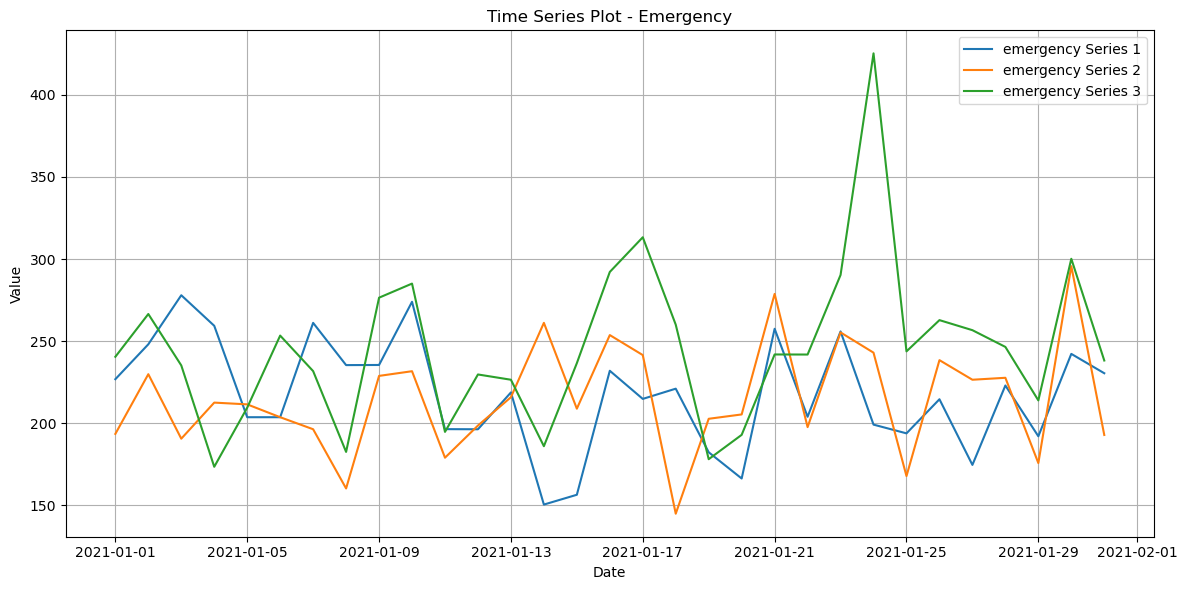

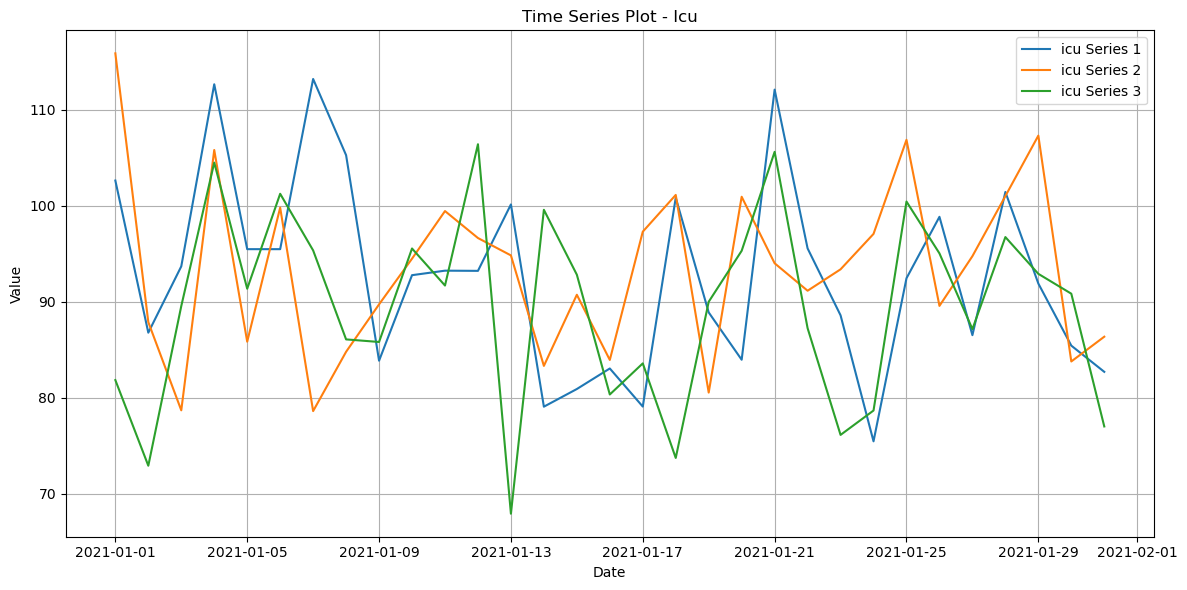

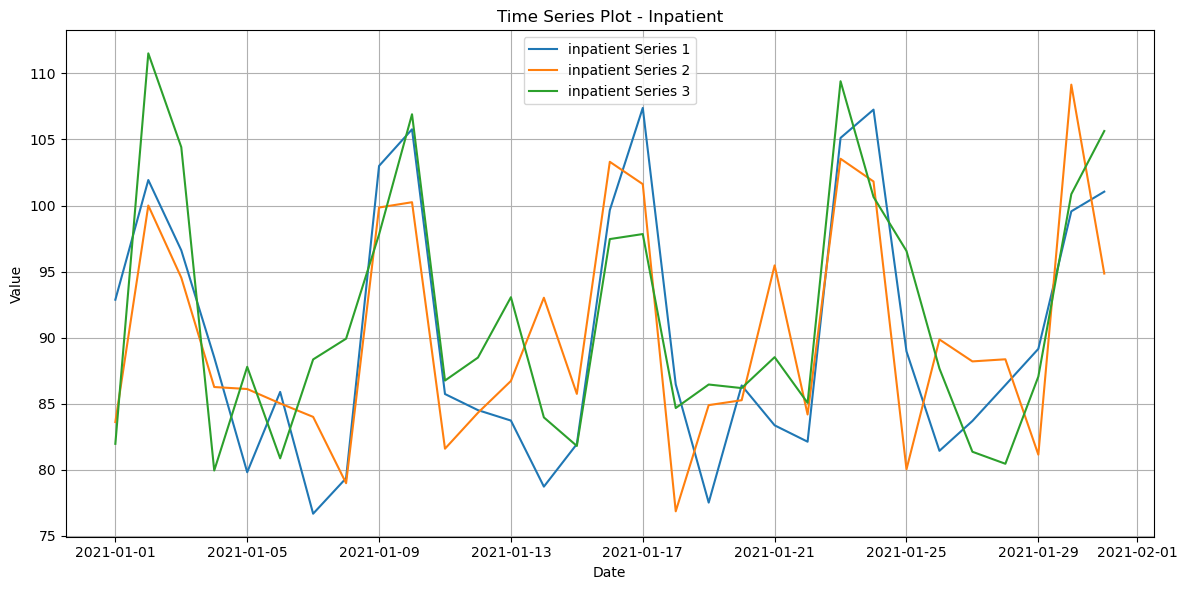

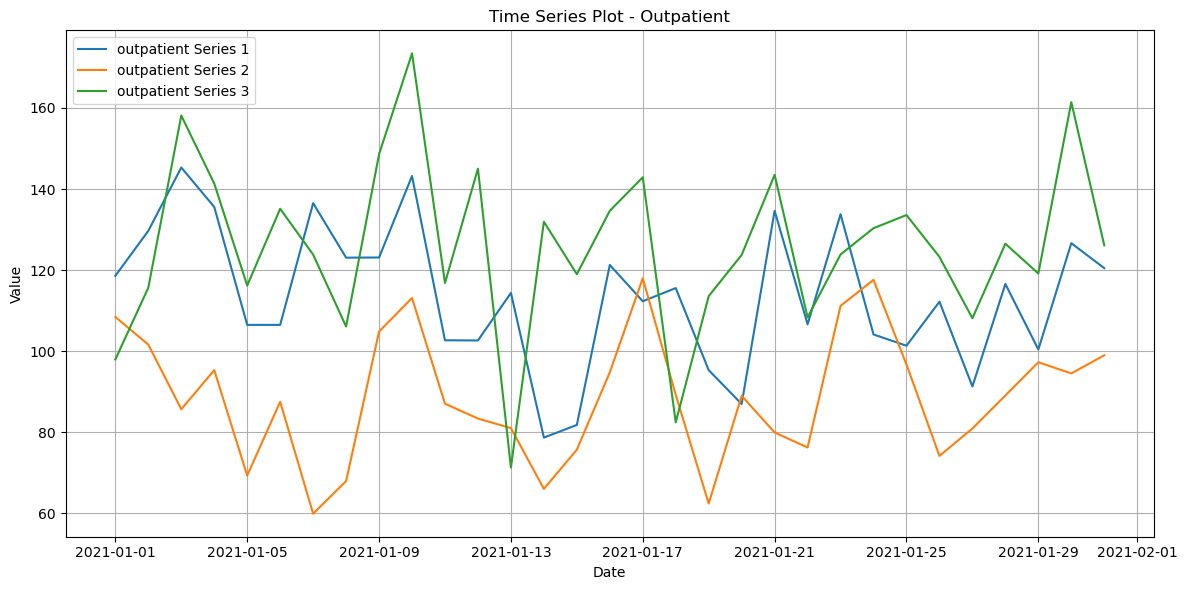

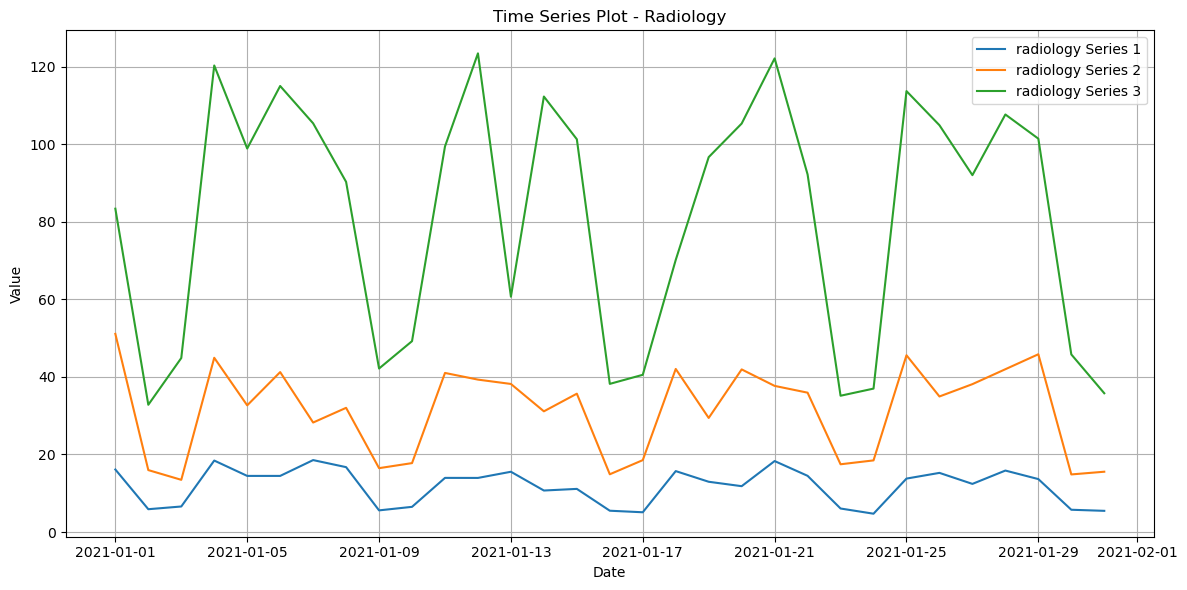

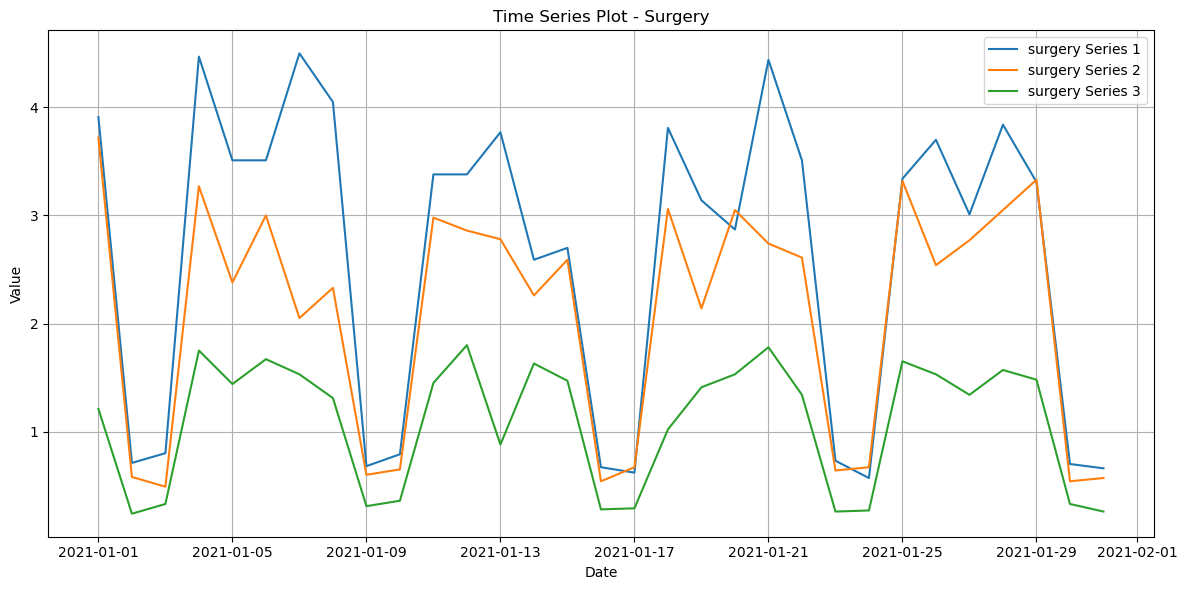

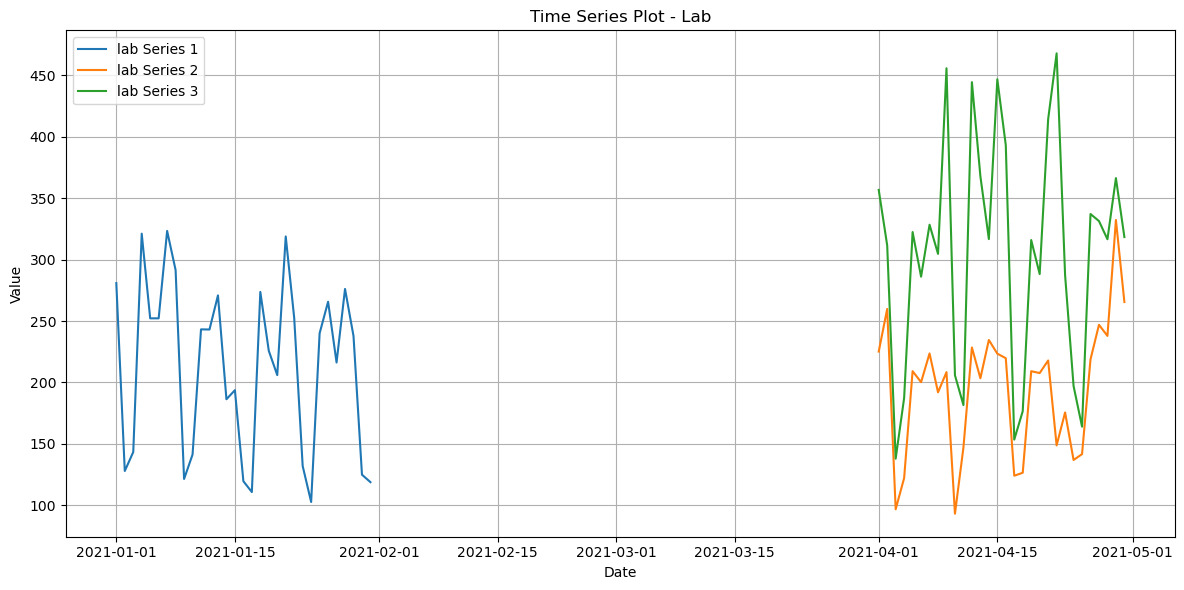

In [16]:
parse_and_plot_timeseries(daily_text_data)

In [12]:
query = "SELECT * FROM AwsDataCatalog.insightsrx_db.department LIMIT 100"
df = pd.read_sql(query, conn)

print(df.head())

/tmp/ipykernel_15583/437574076.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


  department_id hospital_id        department_name floor_number  \
0       DEPT001     HOSP001   Emergency Department            1   
1       DEPT002     HOSP001         Inpatient Ward            3   
2       DEPT051     HOSP001  Outpatient Department            2   
3       DEPT052     HOSP001     Surgery Department            4   
4       DEPT041     HOSP001   Radiology Department            2   

       head_of_department  active_status  
0            Aaryahi Chad           True  
1            Shray Korpal           True  
2           Neelofar Kaur           True  
3              Ela Master           True  
4  Divyansh Krishnamurthy           True  
